In [1]:
using PyPlot;

In [2]:
include("src/utils.jl");

# Problem 18.1 #

The Lambert W function is the unique value $x\ge 0$ satisfying $xe^x = u$. This can be treated as solving the nonlinear least squares problem

\begin{align*}
\text{minimize}_x &\quad (xe^x - u)^2
\end{align*}

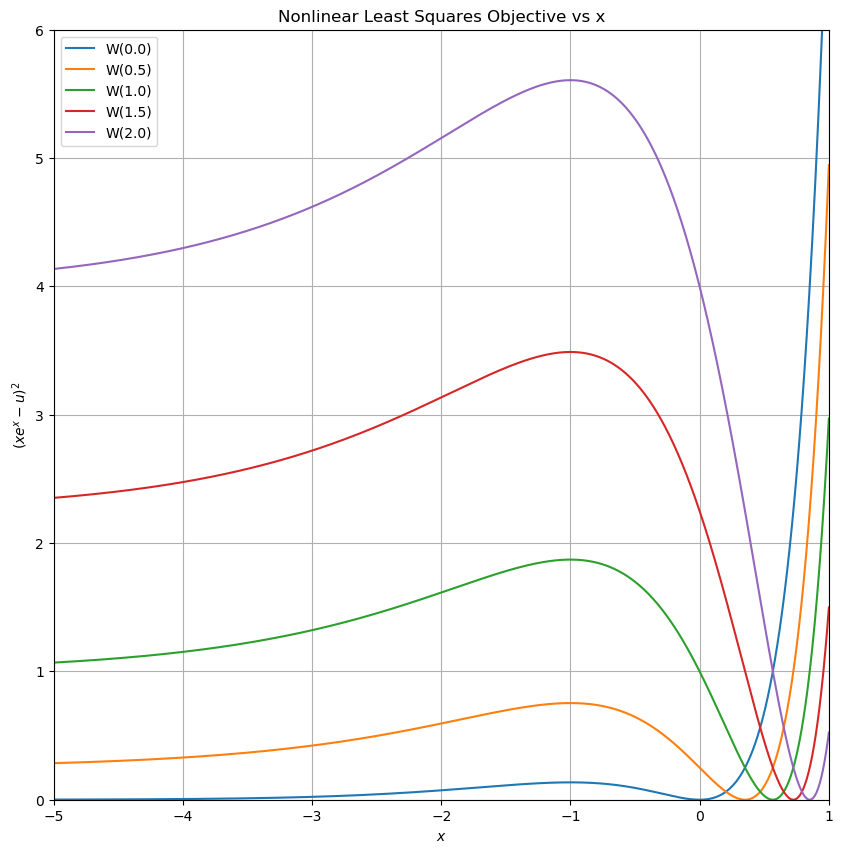

In [7]:
figure(figsize=(10,10));

for i in 0:0.5:2    
    x = linspace(-8,  1.5, 2000);
    plot(x, (x .* exp.(x) - i).^2, label="W($i)");
end
grid(true);
legend();

xlabel(L"x");
title("Nonlinear Least Squares Objective vs x")
ylabel(L"$(xe^x - u)^2$");

xlim([-5, 1]);
ylim([0, 6]);

## Part A ##

Given the objective function for computing _Lambert-W function_ we have
\begin{align*}
    f(x) &= (xe^x - u)\\
    \implies f'(x) &= e^x(x+1)\\
\end{align*}

The update rule for the Levenberg-Marquardt algorithm are
\begin{align*}
    \hat{f}(x;x^{(k)}) &= (x^{(k)}e^{x^{(k)}} - u) + e^{x^{(k)}}(x^{(k)}+1)(x - x^{(k)})\\
    x^{(k+1)} &= x^{(k)} - \frac{e^{x^{(k)}}(x^{(k)}+1)}{\lambda^{(k)} + \left(e^{x^{(k)}}(x^{(k)}+1)\right)^2}(x^{(k)}e^{x^{(k)}} - u)
\end{align*}

## Part B##

In [8]:
xinit = 1;
xplot = linspace(0,10,100);
yplot = [Inf];

for i in xplot
    xvals, fvals, gradnorm, lambdavals = levenberg_marquardt((1,1), x -> (x .* exp.(x) - i), x -> exp.(x) .* (x + 1); xinit=xinit, max_iters=20, atol=1e-6);
    xinit = xvals[end];
    yplot = hcat(yplot, xinit);
end

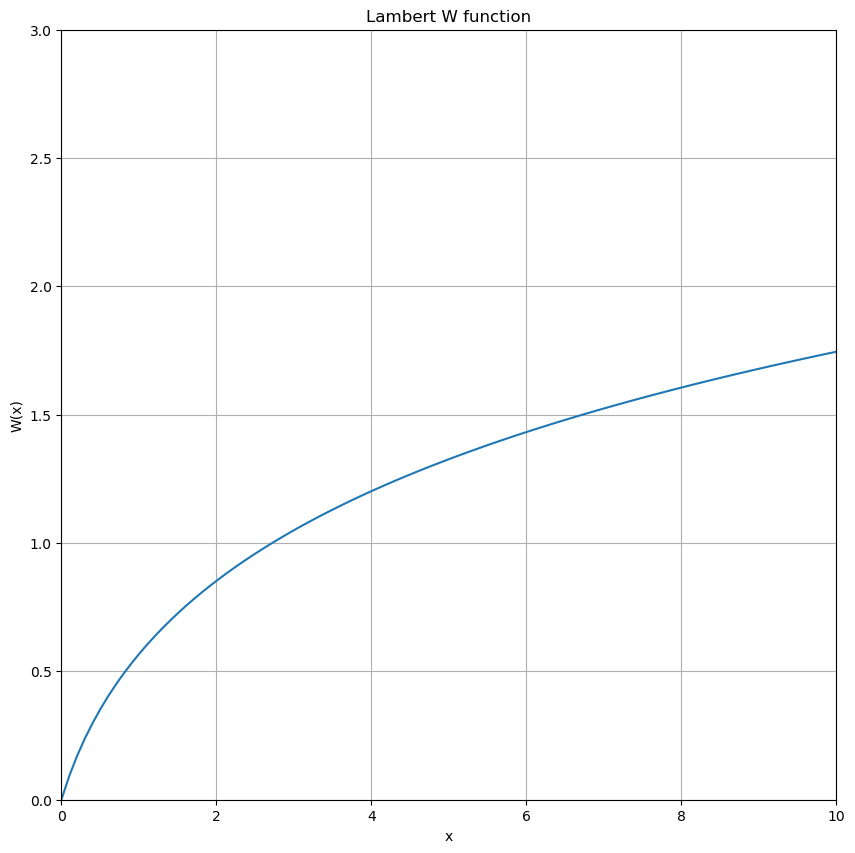

In [9]:
figure(figsize=(10,10));

plot(xplot, yplot[2:end]);
xlim([0, 10])
ylim([0, 3])
grid(true)

title("Lambert W function");
xlabel("x");
ylabel("W(x)");

# Problem 18.2 #

The Net Present Value with interest rate $r$ is given by

$$ N(r) = \sum_{i=1}^n \frac{c_i}{(1+r)^{i-1}} $$

To find the internal rate of return we try to solve the nonlinear equation $N(r) = 0$ by turning it into a nonlinear least squares problem and using the Levenberg-Marquardt algorithm. Since we have only a single equation, we need only the single partial derivative

$$\frac{\mathrm{d}N(r)}{\mathrm{d}r} = \sum_{i=1}^n -(i-1)\frac{c_i}{(1+r)^{i}}$$

In [10]:
c = vcat(-ones(3), 0.5*ones(5), 0.6*ones(6));
n = length(c);

r_vals = linspace(0, 20, 2000);
N_vals = [net_present_value(c, r)^2 for r in r_vals];

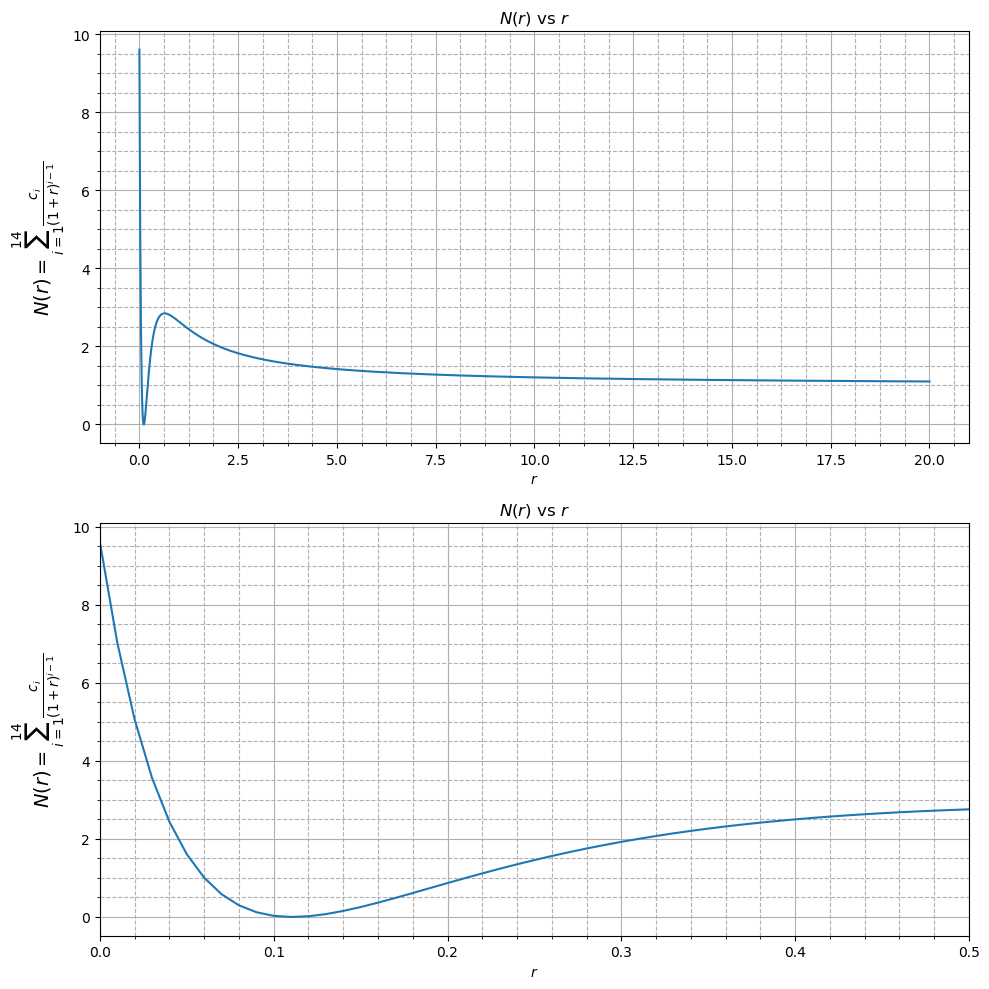

In [11]:
figure(figsize=(10,10));

subplot(211);
plot(r_vals, N_vals);
title(L"$N(r)$ vs $r$");
xlabel(L"$r$");
ylabel(L"$N(r)=\sum_{i=1}^{14} \frac{c_i}{(1+r)^{i-1}}$", fontsize=14);

PyPlot.minorticks_on();
grid(true, which="major");
grid(true, which="minor", linestyle="--");

subplot(212);
plot(r_vals, N_vals);
title(L"$N(r)$ vs $r$");
xlabel(L"$r$");
ylabel(L"$N(r)=\sum_{i=1}^{14} \frac{c_i}{(1+r)^{i-1}}$", fontsize=14);
xlim([0,0.5]);

PyPlot.minorticks_on()
grid(true, which="major");
grid(true, which="minor", linestyle="--");

PyPlot.tight_layout();

In [12]:
thetavals, fvals, gradnorm, lambdavals = levenberg_marquardt((1,1), 
                                                            r -> sum(c .* (1 + r).^(-(0:n-1))), 
                                                            r -> sum(-(0:n-1) .* c .* (1 + r).^(-(1:n)));
                                                            xinit=0.0, max_iters=10, atol=1e-6);

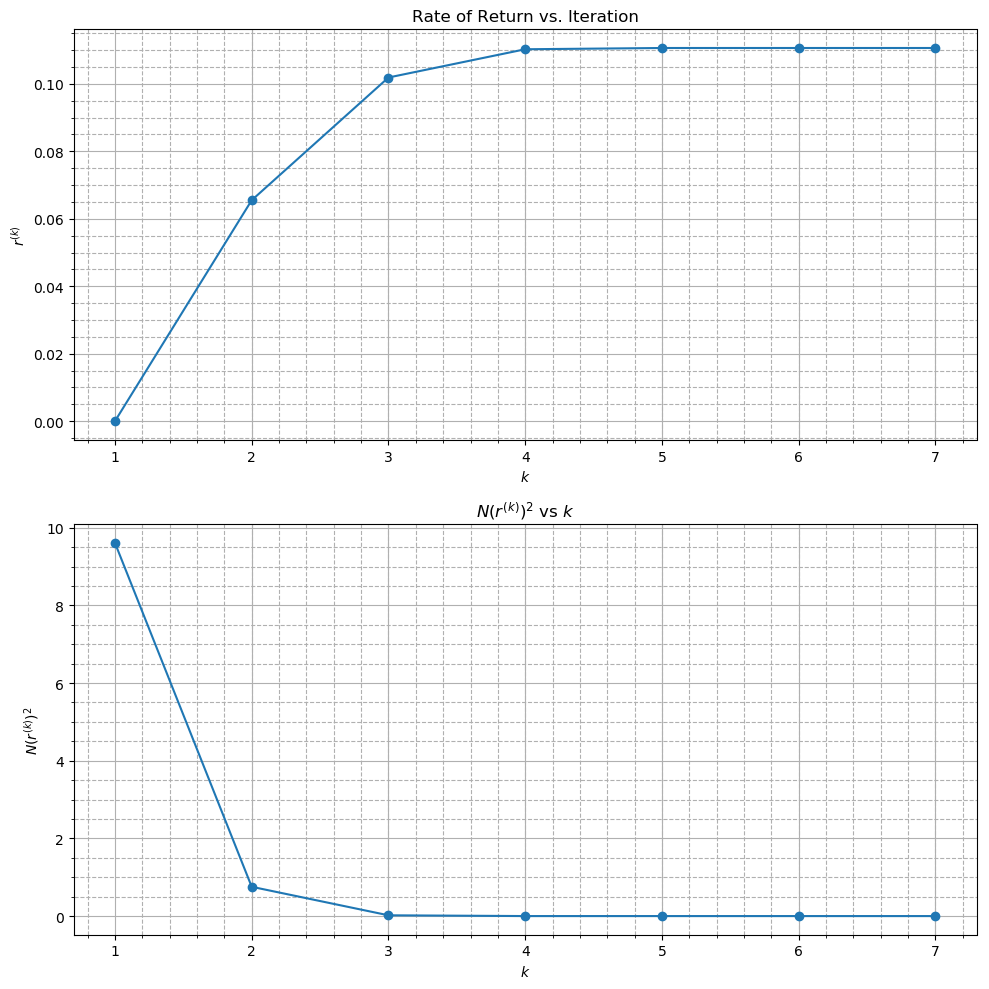

In [13]:
figure(figsize=(10,10))

subplot(211);
plot(vec(1:length(thetavals)), thetavals', marker="o");
title("Rate of Return vs. Iteration");
xlabel(L"$k$");
ylabel(L"$r^{(k)}$");

PyPlot.minorticks_on()
grid(true, which="major");
grid(true, which="minor", linestyle="--");

subplot(212);
plot(vec(1:length(thetavals)), (fvals').^2, marker="o");
title(L"$N\left(r^{(k)}\right)^2$ vs $k$");
xlabel(L"$k$");
ylabel(L"$N\left(r^{(k)}\right)^2$");

PyPlot.minorticks_on();
grid(true, which="major");
grid(true, which="minor", linestyle="--");

PyPlot.tight_layout();

# Problem 18.3 #

If the residual of the nonlinear least squares problem takes the form 

$$ f_i(x) = \phi_i(a_i^Tx - b_i)$$

Then objective is to minimize 

$$ J = \sum_{i=1}^N \left(\phi_i(a_i^Tx - b_i)\right)^2 $$.

To use the Levenberg-Marquardt algorithm we need to compute the Jacobian of $f(x)$ wrt $x$.

\begin{align*}
\frac{\partial f_i}{\partial x_j} &= \frac{\partial }{\partial x_j} \left(\phi_i(a_i^Tx - b_i)\right)\\
&= \phi'_i(a_i^Tx - b_i) \cdot a_{ij}\\
\end{align*}

Finding the partials with respect to each $x$ we can compute the Jacobian of $f_i(x)$ as

$$Df_i(x) =  \phi'_i(a_i^Tx - b_i) \cdot a_i^T $$

The Jacobian of $f(x)$ is simply the concatentation of all $Df_i(x)$

\begin{align*}
Df(x) &=  \begin{bmatrix}
\phi'_1(a_1^Tx - b_1) \cdot a_1^T\\
\phi'_2(a_2^Tx - b_2) \cdot a_2^T\\
\phi'_3(a_1^Tx - b_3) \cdot a_3^T\\
\vdots \\
\phi'_N(a_N^Tx - b_N) \cdot a_N^T
\end{bmatrix}\\[9pt]
&= \mathbf{diag}\left(\phi'_1(a_1^Tx - b_1), \phi'_2(a_2^Tx - b_2) , \ldots,\phi'_N(a_N^Tx - b_N)\right)A
\end{align*}


# Problem 18.4 #

Considering the model 
$$\hat{f}(x;\theta) = \theta_1 e^{\theta_2 x}$$
we find the gradient to be
$$ \nabla_\theta \hat{f}(x;\theta)   = 
\begin{bmatrix}
e^{\theta_2 x} \\
\theta_1 x\cdot e^{\theta_2 x}
\end{bmatrix}
$$
To fit the model to $N$ datapoints we have to solve the nonlinear set of equations

$$
\begin{align*}
    \theta_1 e^{\theta_2 x^{(1)}} - y^{(1)} &= 0\\
    \theta_1 e^{\theta_2 x^{(2)}} - y^{(2)} &= 0\\
    &\ \ \vdots\\
    \theta_1 e^{\theta_2 x^{(N-1)}} - y^{(N-1)} &= 0\\
    \theta_1 e^{\theta_2 x^{(N)}} - y^{(N)} &= 0
\end{align*}
$$

As a heuristic we can instead solve the nonlinear least squares problem using the Levenberg-Marquardt algorithm

In [14]:
xdata = [0; 1; 2; 3; 4; 5];
ydata = [5.2; 4.5; 2.7; 2.5; 2.1; 1.9];
n = length(xdata);

In [15]:
function exp_model{T <: Real}(theta::Array{T,1})
    return theta[1] * exp.(theta[2] * xdata) - ydata;
end

function exp_model_jacobian{T <: Real}(theta::Array{T,1})
    return [exp.(theta[2] * xdata) theta[1] * xdata .* exp.(theta[2] * xdata)]
end

exp_model_jacobian (generic function with 1 method)

In [16]:
thetavals_lm, fvals_lm, gradnorm_lm, lambdavals_lm = levenberg_marquardt((2, n), exp_model, exp_model_jacobian; xinit=ones(2), max_iters=10, atol=1e-6);

In [17]:
thetavals_gn, fvals_gn, gradnorm_gn = gauss_newton((2, n), exp_model, exp_model_jacobian; xinit=ones(2), max_iters=10, atol=1e-6);

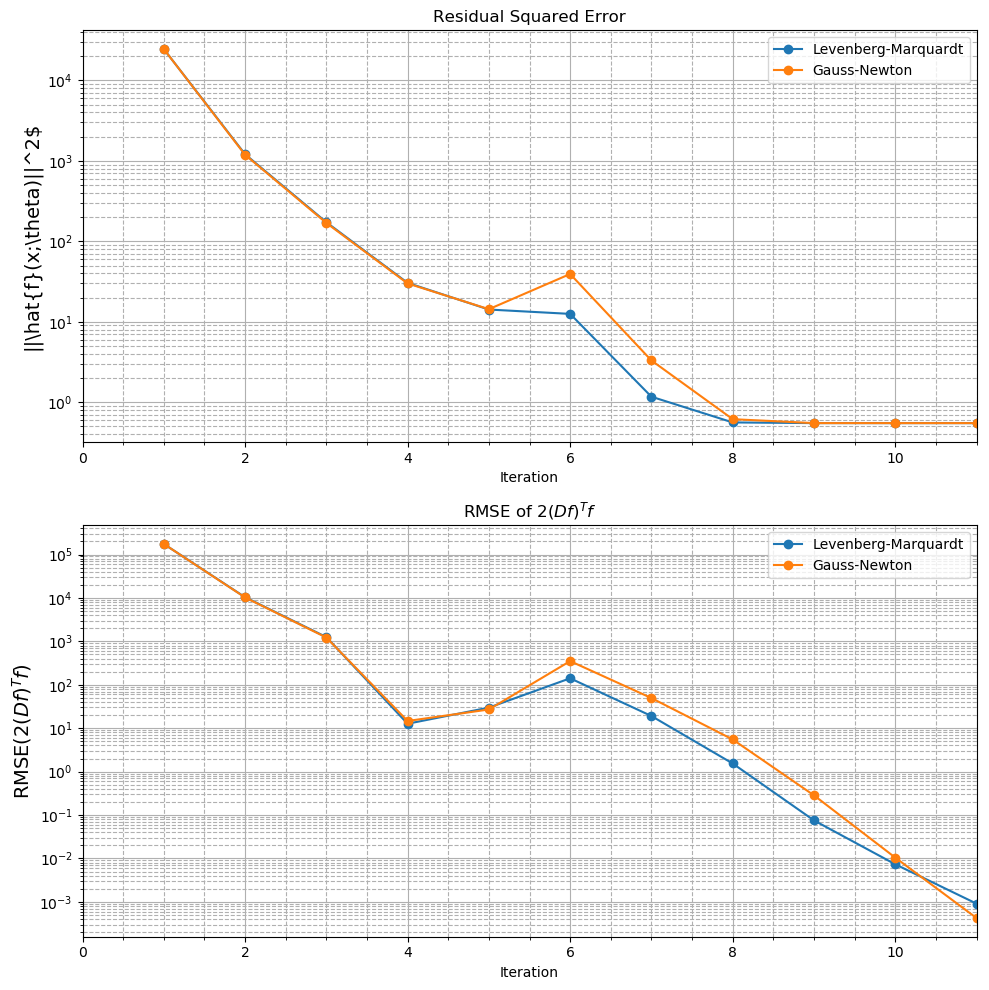

In [18]:
figure(figsize=(10,10))

num_points = size(thetavals_lm, 2);
nnls_cost_lm = vec(sum(fvals_lm.^2, 1));
nnls_cost_gn = vec(sum(fvals_gn.^2, 1));

ax = subplot(211);
semilogy(vec(1:num_points), (nnls_cost_lm), marker="o",label="Levenberg-Marquardt");
semilogy(vec(1:num_points), (nnls_cost_gn), marker="o", label="Gauss-Newton");
grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on()
legend();
title("Residual Squared Error")
xlabel("Iteration")
ylabel(L"||\hat{f}(x;\theta)||^2$", fontsize=14)
xlim([0, num_points]);

subplot(212);
semilogy(vec(1:num_points), vec(gradnorm_lm), marker="o",label="Levenberg-Marquardt");
semilogy(vec(1:num_points), vec(gradnorm_gn), marker="o", label="Gauss-Newton");
grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on()
legend();

title(L"RMSE of $2(Df)^Tf$")
xlabel("Iteration")
ylabel(L"RMSE($2(Df)^Tf$)", fontsize=14)
xlim([0, num_points]);

PyPlot.tight_layout()

By taking the logarithm of the model, we see that it is linear in the parameters $\log(\theta_1)$ and $\theta_2$

$$ \log \hat{f}(x;\theta) = \log(\theta_1) +  \theta_2 x$$

To fit the model to $N$ datapoints we simply solve the following least squares problem 

$$\text{minimize}\quad
\left\lVert
\begin{bmatrix}
1 & x^{(1)} \\
1 & x^{(2)} \\
\vdots & \vdots \\
1 &  x^{(N)} \\
\end{bmatrix}
\begin{bmatrix}
\log(\theta_1)\\
\theta_2
\end{bmatrix} -
\begin{bmatrix}
\log(y^{(1)})\\
\log(y^{(2)})\\
\vdots\\
\log(y^{(N)})
\end{bmatrix}
\right\rVert^2
$$


In [19]:
A = vandermonde(xdata, 1);
b = log.(ydata);

In [20]:
x_ls = A \ b;
theta1_ls = exp(x_ls[1]);
theta2_ls = x_ls[2];

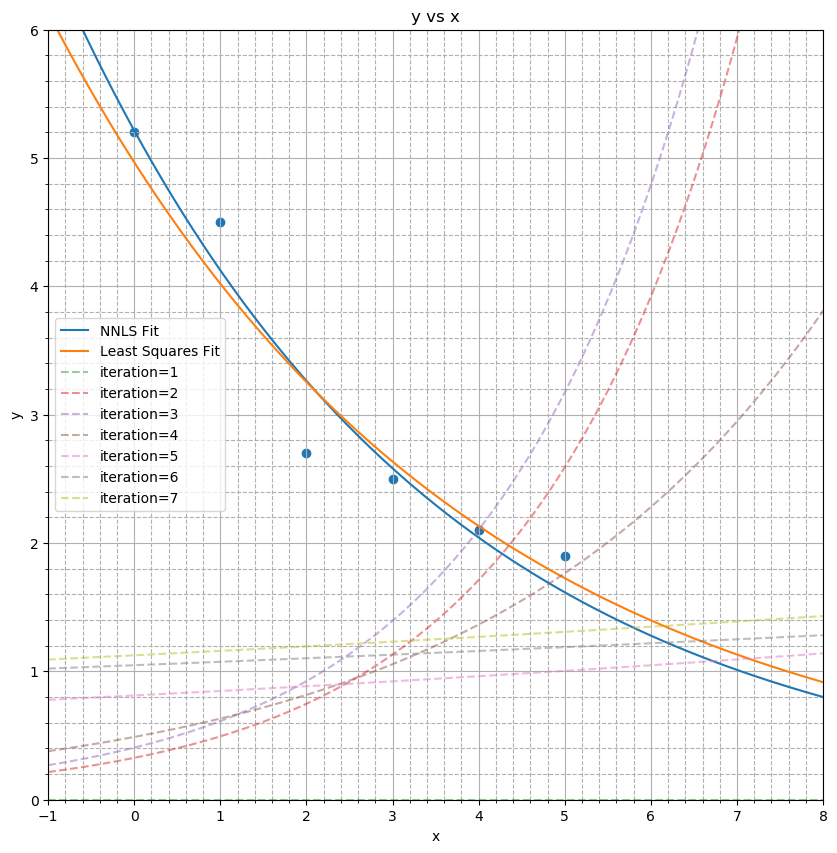

In [44]:
figure(figsize=(10,10));

xplot_points = vec(linspace(-1,8,1000));
yplot_points = thetavals_lm[1,end] * exp.(thetavals_lm[2,end] * xplot_points);
plot(xplot_points, yplot_points, label="NNLS Fit")
plot(xplot_points, theta1_ls * exp.(theta2_ls * xplot_points), label="Least Squares Fit");

for i = 1:7
    plot(xplot_points, thetavals[1,i] * exp.(thetavals[2,i] * xplot_points), "--", alpha=0.5, label="iteration=$i")
end

scatter(xdata, ydata);
PyPlot.minorticks_on()
grid(true, which="major");
grid(true, which="minor",linestyle="--");
legend();

xlim([-1, 8])
ylim([0, 6])
title("y vs x")
xlabel("x");
ylabel("y");


In [45]:
theta1 = vec(linspace(0, 8, 500));
theta2 = vec(linspace(-4, 1, 500));

X = repmat(theta1, 1, 500);
Y = repmat(theta2', 500, 1);
Z = [sum(exp_model(vec([i j])).^2) for i in theta1, j in theta2];

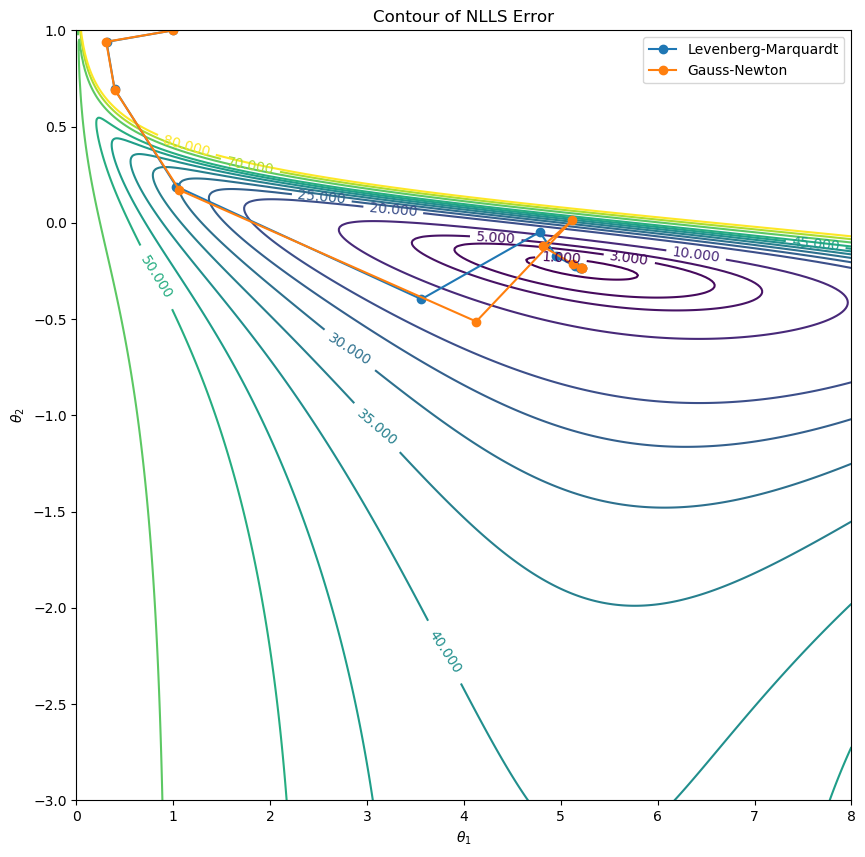

In [46]:
figure(figsize=(10,10))

plot(thetavals_lm[1,:], thetavals_lm[2,:], marker="o", label="Levenberg-Marquardt")
plot(thetavals_gn[1,:], thetavals_gn[2,:], marker="o", label="Gauss-Newton");
cs = contour(X, Y, Z, [1, 3, 5, 10, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]);
clabel(cs, inline=1, fontsize=10);

title("Contour of NLLS Error");
xlabel(L"$\theta_1$");
ylabel(L"$\theta_2$");
legend();

ylim([-3, 1]);
xlim([0, 8]);

# Problem 18.5 #

Consider a mass held between two anchor points under the force of gravity. The mass is attached to two cables, each tied to one of the anchor points. The equilibrium position of the mass can be determined by solving

$$ F^{grav} + F_1 + F_2 = 0$$

Where $F^{grav}$, $F_1$, $F_2\in \mathbf{R}^2$ give the force of gravity, the force of cable 1, and the force of cable 2 on the mass.

The forces are given by 
\begin{align*}
F^{grav} &=    -mg
\begin{bmatrix}
0\\
1
\end{bmatrix}\\[6pt]
F_1 &= \frac{k}{L_1} \frac{\max\{||a_1 -x||-L_1,0\} }{||a_1-x||}
\begin{bmatrix}
a_{11}-x_1\\
a_{12} - x_2
\end{bmatrix}\\[6pt]
F_2 &= \frac{k}{L_2} \frac{\max\{||a_2 - x|| - L_2, 0\} }{||a_2-x||}
\begin{bmatrix}
a_{21}-x_1\\
a_{22} - x_2
\end{bmatrix}
\end{align*}


To compute the jacobian $J\in\mathbf{R}^{2\times 2}$ we first note that $F^{grav}$ is constant so it can be ignored. We also note $D(F_1 +F_2) = DF_1 + DF_2$. The following partial derivatives are useful for computing the jacobian matrix.

\begin{align*}
\frac{\partial}{\partial x_k} \max\{||b - x|| - c,0\} &= \frac{x_k - b_k}{||x-b||}\cdot \mathbf{1}\left(||x-b|| > L\right)\\[6pt]
\frac{\partial}{\partial x_k} \frac{1}{||b - x||} &= \frac{b_k - x_k}{||b - x||^3}
\end{align*}

From these deriviatives we have immediately that 

\begin{align*}\frac{\partial F_{ik}}{\partial x_j} &= \frac{k}{L_i}\left(\frac{a_{ik}-x_k}{||a_i - x||}\frac{\partial }{\partial x_j}\left(\max\{||a_i-x||-L_i, 0\}\right) + (a_{ik}-x_k)\max\{||a_1-x||-L_i, 0\}\frac{\partial }{\partial x_j}\frac{1}{||a_i -x||}  + \frac{\max\{||a_i - x||-L_i,0\} }{||a_i-x||}\frac{\partial }{\partial x_j}(a_{ik}-x_k) \right)\\
&= \frac{k}{L_i}\left(-\frac{(a_{ik}-x_k)(a_{ij}-x_j)}{||a_i - x||^2}\cdot\mathbf{1}\left(||x-a_i|| > L_i\right) + \frac{(a_{ik}-x_k)(a_{ij} - x_j)}{||a_i - x||^3}\cdot\max\{||a_i-x||-L_i, 0\}  - \frac{\max\{||a_i - x||-L_i,0\} }{||a_i-x||}\cdot \mathbf{1}(k=j) \right)\\
\end{align*}

In [24]:
a1 = vec([3.0 2.0]);
a2 = vec([-1.0 1.0]);
L1 = 3;
L2 = 2;
m = 1;
k = 100;
g = 9.8;
n = length(a1);

In [25]:
function tension_force_balance(x::Vector{T}) where T <: Real
    d1 = norm(a1 - x);
    d2 = norm(a2 - x);
    tension1 = k / L1 * max(d1 - L1, 0);
    tension2 = k / L2 * max(d2 - L2, 0);
    F1 = tension1 * (a1 - x) / d1;
    F2 = tension2 * (a2 - x) / d2;
    Fgrav = -m * g * vec([0 1]);
    
    return Fgrav + F1 + F2
end

function tension_force_jacobian(x::Vector{T}, a::Vector{T}, L::U, k::U) where T <: Real where U <: Real
    n = length(a);
    dist = norm(x - a);
    deriv1 = -(a - x) .* (a - x)' * (dist > L) / dist^2 ;
    deriv2 = (a - x) .* (a - x)' / dist^3 * max(dist - L, 0);
    deriv3 = -max(dist - L, 0) * eye(n,n);
    
    return k / L * (deriv1 + deriv2 + deriv3);
end

function tension_force_balance_jacobian(x::Array{T,1}) where T <: Real
    return tension_force_jacobian(x, a1, L1, k) + tension_force_jacobian(x, a2, L2, k)
end



tension_force_balance_jacobian (generic function with 1 method)

In [26]:
xvals_lm, fvals_lm, gradnorm_lm, lambdavals_lm = levenberg_marquardt((n, n), tension_force_balance, tension_force_balance_jacobian; xinit=zeros(n), max_iters=30, atol=1e-6);

In [27]:
xvals_gn, fvals_gn, gradnorm_gn = gauss_newton((n, n), tension_force_balance, tension_force_balance_jacobian; xinit=zeros(n), max_iters=30, atol=1e-6);

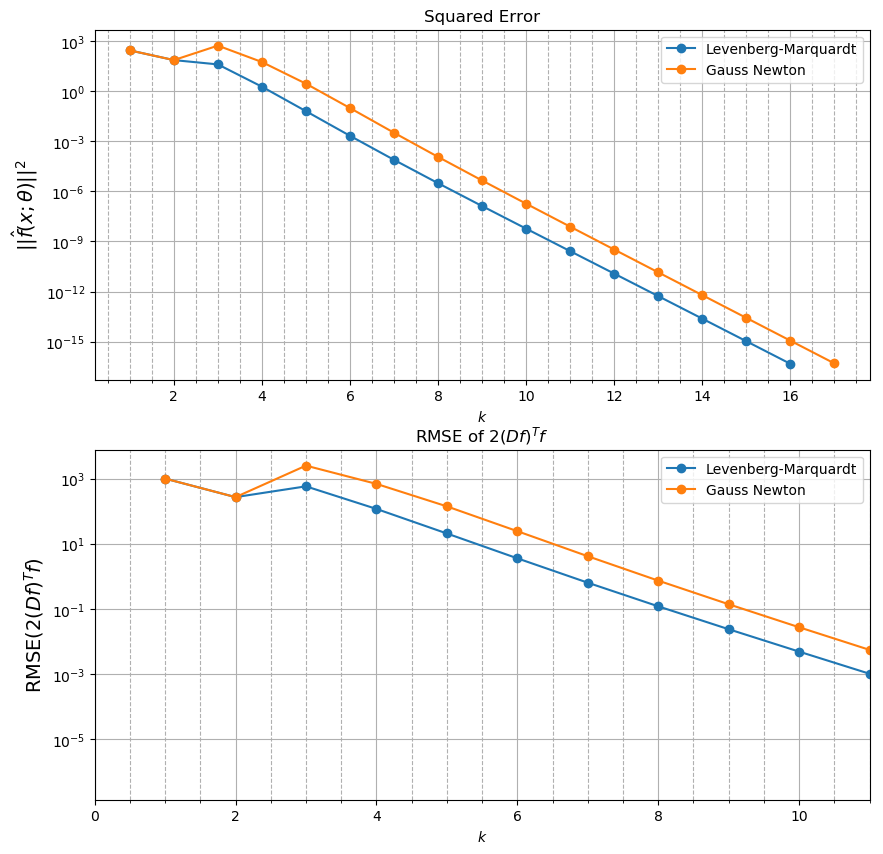

In [28]:
figure(figsize=(10,10))

num_points_lm = size(xvals_lm, 2);
nnls_cost_lm = vec(sum(fvals_lm.^2, 1));

num_points_gn = size(xvals_gn, 2);
nnls_cost_gn = vec(sum(fvals_gn.^2, 1));

subplot(211);
semilogy(vec(1:num_points_lm), nnls_cost_lm, marker="o",label="Levenberg-Marquardt");
semilogy(vec(1:num_points_gn), nnls_cost_gn, marker="o",label="Gauss Newton");
PyPlot.minorticks_on()
grid(true, which="major");
grid(true, which="minor",linestyle="--");
legend();

title("Squared Error");
xlabel(L"$k$");
ylabel(L"$||\hat{f}(x;\theta)||^2$", fontsize=14);


subplot(212);
semilogy(vec(1:num_points_lm), vec(gradnorm_lm), marker="o",label="Levenberg-Marquardt");
semilogy(vec(1:num_points_gn), vec(gradnorm_gn), marker="o", label="Gauss Newton");
grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on()
legend();

title(L"RMSE of $2(Df)^Tf$")
xlabel(L"$k$")
ylabel(L"RMSE($2(Df)^Tf$)", fontsize=14)
xlim([0, num_points]);

In [29]:
num_points = 1000;
x1 = vec(linspace(0.0, 1.3, num_points));
x2 = vec(linspace(-1, 0.75, num_points));

X = repmat(x1, 1, num_points);
Y = repmat(x2', num_points, 1);
Z = [sum(tension_force_balance(vec([i j])).^2) for i in x1, j in x2];

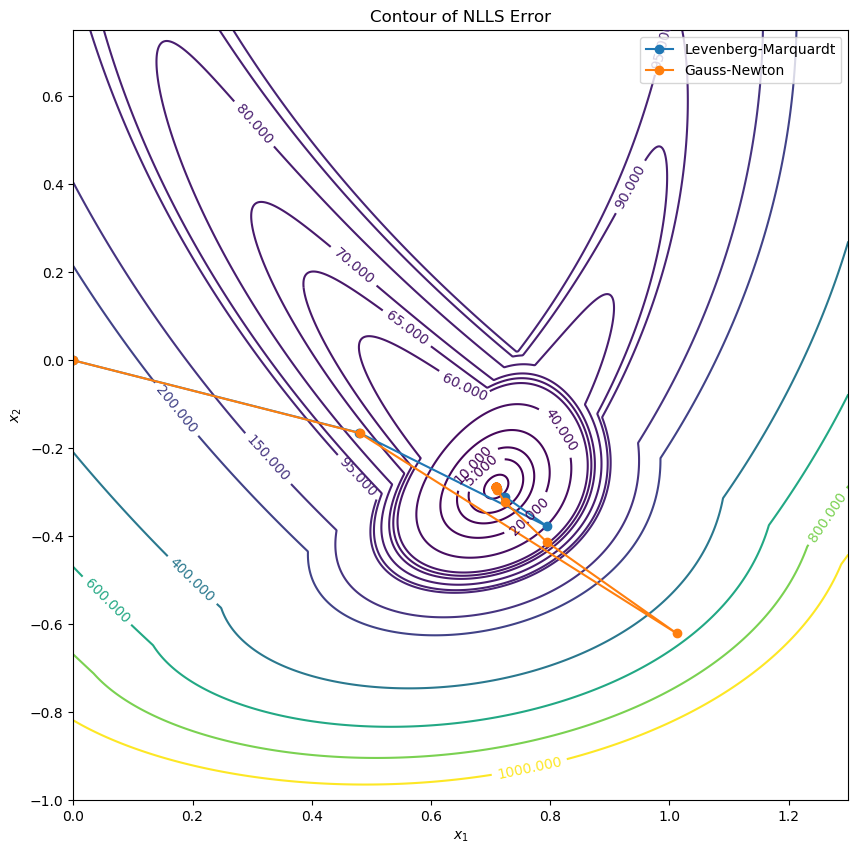

In [30]:
figure(figsize=(10,10));

plot(xvals_lm[1,:], xvals_lm[2,:], marker="o", label="Levenberg-Marquardt")
plot(xvals_gn[1,:], xvals_gn[2,:], marker="o", label="Gauss-Newton");
cs = contour(X, Y, Z, [1, 5, 10, 20, 40, 60, 65, 70, 80, 90, 95, 150, 200, 400, 600, 800, 1000]);
clabel(cs, inline=1, fontsize=10);

title("Contour of NLLS Error");
xlabel(L"$x_1$");
ylabel(L"$x_2$");
legend();

xlim([0.0, 1.3]);
ylim([-1, 0.75]);

# Problem 18.7 #

The position of the end of a robot arm is described by 
$$p = L_1
\begin{bmatrix}
\cos \theta_1\\
\sin \theta_1
\end{bmatrix} +
L_2 \begin{bmatrix}
\cos (\theta_1 + \theta_2)\\
\sin(\theta_1+\theta_2)
\end{bmatrix}
$$

where $\theta_1$ and $\theta_2$ are the joint angle of the first and second linkage of the arm. Given a final position $p^{des}$ we can find the joint angles by solving the 2 x 2 system on nonlinear equations using the Levenberg-Marquardt algorithm.

In [31]:
L1 = 2;
L2 = 1;

p1 = vec([1.0, 0.5]);
p2 = vec([-2.0, 1.0]); 
p3 = vec([-0.2, 3.1]);

In [32]:
function robot_arm_position(theta::Vector{T}) where T <: Real
    angle_sum = theta[1] + theta[2];
    a = L1 * vec([cos(theta[1]) sin(theta[1])]);
    b = L2 * vec([cos(angle_sum) sin(angle_sum)]);
    return a + b 
end

function robot_arm_position_jacobian(theta::Vector{T}) where T <: Real
    J11 = -L1 * sin(theta[1]) - L2*sin(theta[1] + theta[2]);
    J12 = -L2 * sin(theta[1] + theta[2]);
    J21 = L1 * cos(theta[1]) + L2*cos(theta[1] + theta[2]);
    J22 = L2 * cos(theta[1] + theta[2]);
    
    return [J11 J12; J21 J22]
end

robot_arm_position_jacobian (generic function with 1 method)

In [33]:
xvals_lm_p1, fvals_lm_p1, gradnorm_lm_p1, lambdavals_lm_p1 = levenberg_marquardt((2, 2), x -> robot_arm_position(x) - p1, robot_arm_position_jacobian; xinit=[3,4], max_iters=30, atol=1e-6);

xvals_lm_p2, fvals_lm_p2, gradnorm_lm_p2, lambdavals_lm_p2 = levenberg_marquardt((2, 2), x -> robot_arm_position(x) - p2, robot_arm_position_jacobian; xinit=[3,4], max_iters=30, atol=1e-6);

xvals_lm_p3, fvals_lm_p3, gradnorm_lm_p3, lambdavals_lm_p3 = levenberg_marquardt((2, 2), x -> robot_arm_position(x) - p3, robot_arm_position_jacobian; xinit=[3,4], max_iters=30, atol=1e-6);


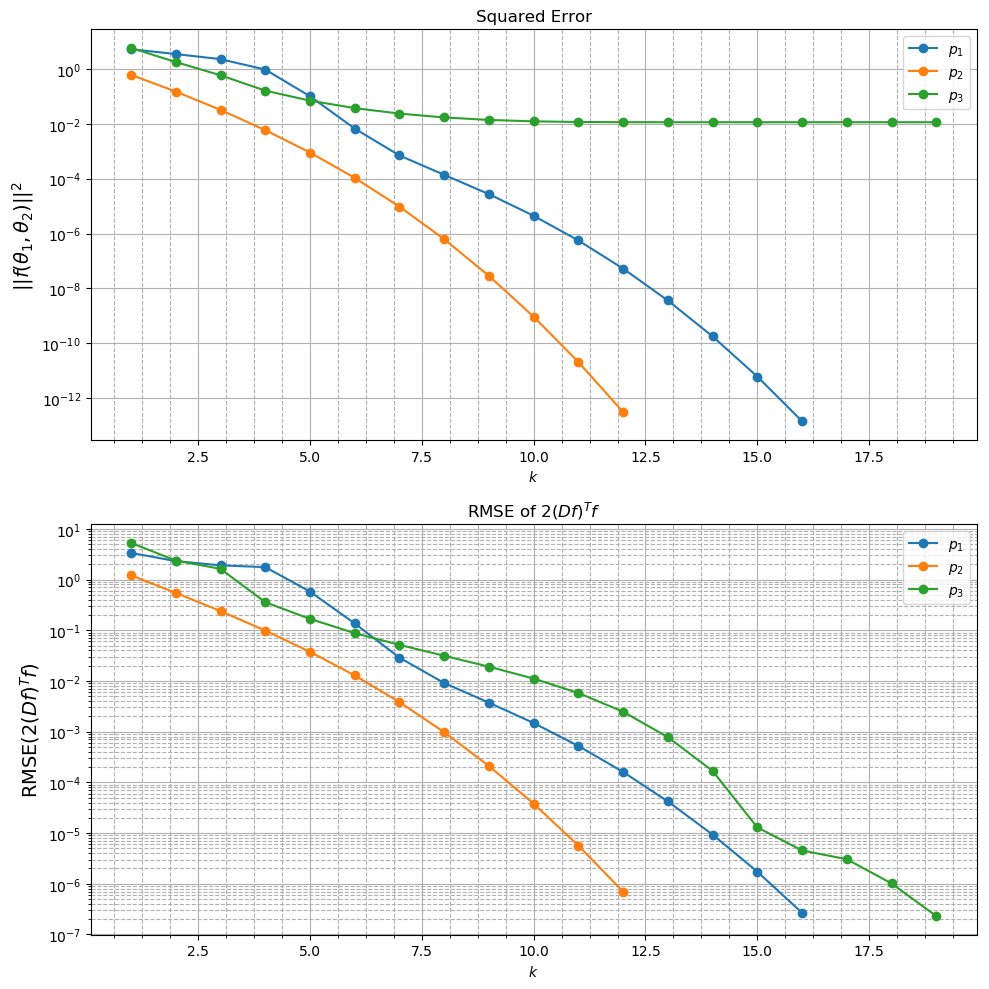

In [34]:
figure(figsize=(10,10))

nnls_cost_lm_p1 = vec(sum(fvals_lm_p1.^2, 1));
nnls_cost_lm_p2 = vec(sum(fvals_lm_p2.^2, 1));
nnls_cost_lm_p3 = vec(sum(fvals_lm_p3.^2, 1));

subplot(211);

semilogy(vec(1:size(xvals_lm_p1, 2)), nnls_cost_lm_p1, marker="o",label=L"$p_1$");
semilogy(vec(1:size(xvals_lm_p2, 2)), nnls_cost_lm_p2, marker="o",label=L"$p_2$");
semilogy(vec(1:size(xvals_lm_p3, 2)), nnls_cost_lm_p3, marker="o",label=L"$p_3$");
grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();
legend();

title("Squared Error");
xlabel(L"$k$");
ylabel(L"$||f(\theta_1,\theta_2)||^2$", fontsize=14);

subplot(212);

semilogy(vec(1:size(xvals_lm_p1, 2)), vec(gradnorm_lm_p1), marker="o",label=L"$p_1$");
semilogy(vec(1:size(xvals_lm_p2, 2)), vec(gradnorm_lm_p2), marker="o",label=L"$p_2$");
semilogy(vec(1:size(xvals_lm_p3, 2)), vec(gradnorm_lm_p3), marker="o",label=L"$p_3$");
grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();
legend();

title(L"RMSE of $2(Df)^Tf$");
xlabel(L"$k$");
ylabel(L"RMSE($2(Df)^Tf$)", fontsize=14);

PyPlot.tight_layout()

We see that for $p_3$ for which the end state is not achievable, the squared error levels out and is not driven to zero

In [35]:
num_points = 1000;
theta1 = vec(linspace(0.0, 2*pi, num_points));
theta2 = vec(linspace(0.0, 2*pi, num_points));

X = repmat(theta1, 1, num_points);
Y = repmat(theta2', num_points, 1);
Z1 = [sum((robot_arm_position(vec([i j])) - p1).^2) for i in theta1, j in theta2];
Z2 = [sum((robot_arm_position(vec([i j])) - p2).^2) for i in theta1, j in theta2];
Z3 = [sum((robot_arm_position(vec([i j])) - p3).^2) for i in theta1, j in theta2];

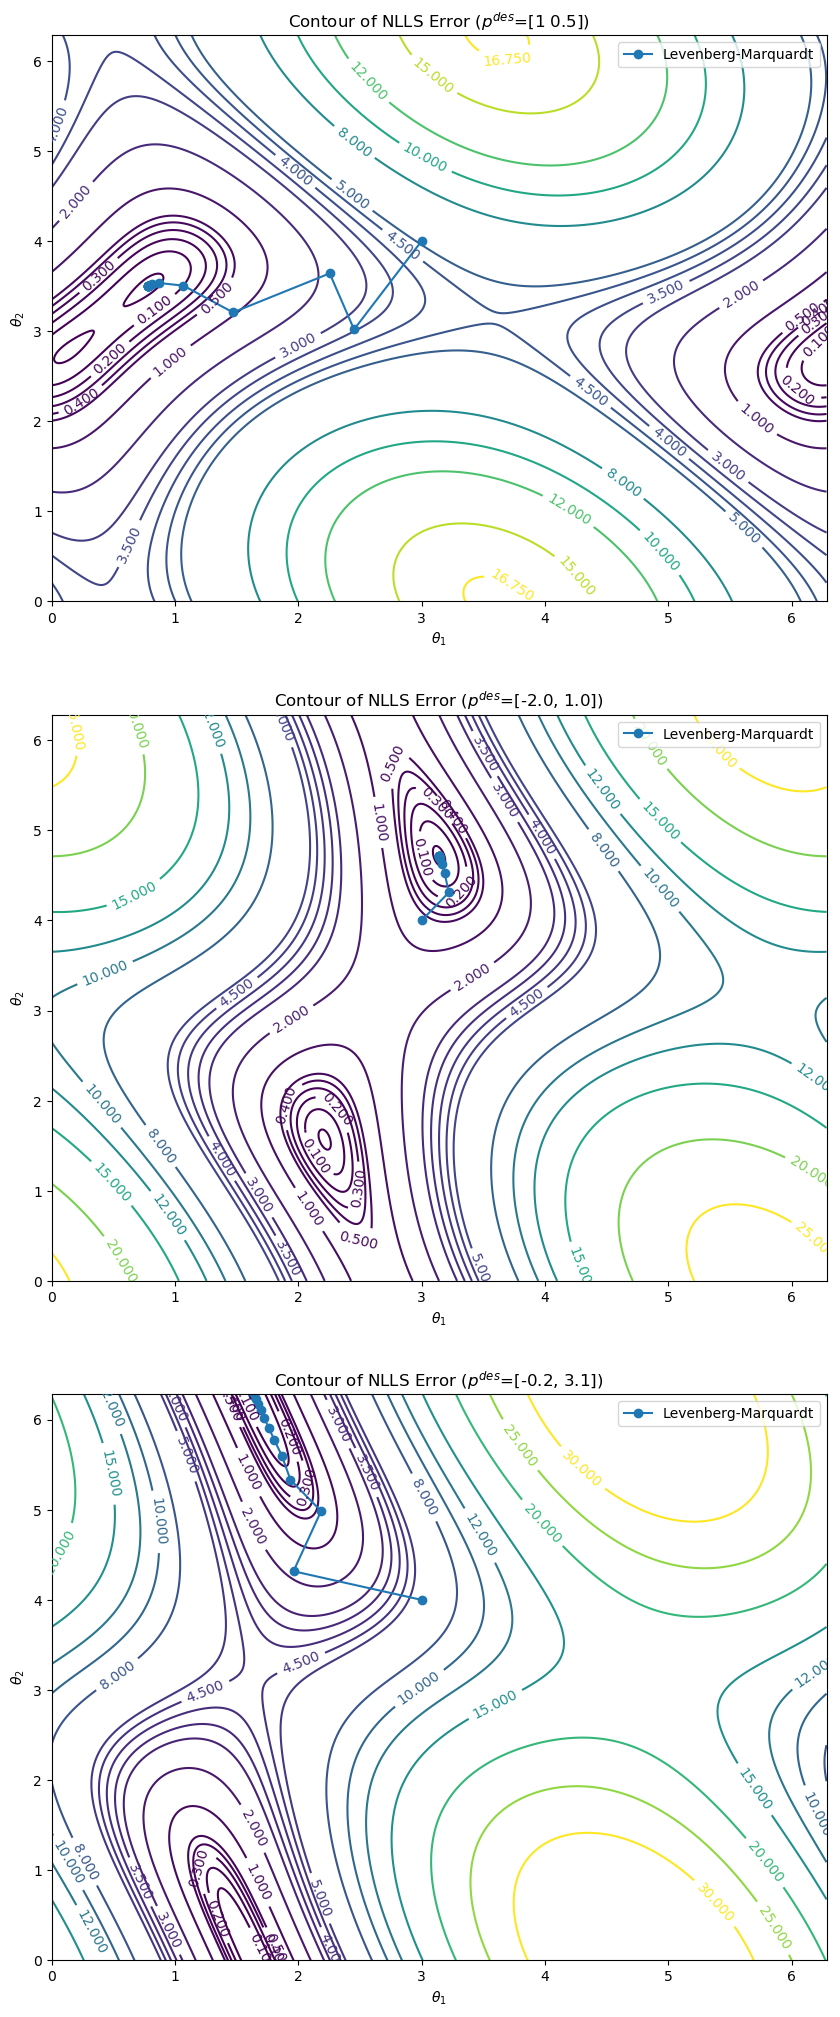

In [36]:
figure(figsize=(10,25));

subplot(311);

plot(xvals_lm_p1[1,:], xvals_lm_p1[2,:], marker="o", label="Levenberg-Marquardt");
cs = contour(X, Y, Z1, [0.01 0.1 0.2 0.3 0.4 0.5 1 2 3 3.5 4 4.5 5 8 10 12 15 16.75]);
clabel(cs, inline=1, fontsize=10);
title(L"Contour of NLLS Error ($p^{des}$=[1 0.5])");
xlabel(L"$\theta_1$");
ylabel(L"$\theta_2$");
legend();

subplot(312);

plot(xvals_lm_p2[1,:], xvals_lm_p2[2,:], marker="o", label="Levenberg-Marquardt");
cs = contour(X, Y, Z2, [0.01 0.1 0.2 0.3 0.4 0.5 1 2 3 3.5 4 4.5 5 8 10 12 15 20 25 30]);
clabel(cs, inline=1, fontsize=10);
title(L"Contour of NLLS Error ($p^{des}$=[-2.0, 1.0])");
xlabel(L"$\theta_1$");
ylabel(L"$\theta_2$");
legend();

subplot(313);
plot(xvals_lm_p3[1,:], xvals_lm_p3[2,:], marker="o", label="Levenberg-Marquardt");

cs = contour(X, Y, Z3, [0.01 0.1 0.2 0.3 0.4 0.5 1 2 3 3.5 4 4.5 5 8 10 12 15 20 25 30]);
clabel(cs, inline=1, fontsize=10);

title(L"Contour of NLLS Error ($p^{des}$=[-0.2, 3.1])");
xlabel(L"$\theta_1$");
ylabel(L"$\theta_2$");
legend();


xlim([0.0, 2*pi]);
ylim([0.0, 2*pi]);

# Problem 18.8 #

An ellipse can be represented in parametric form as 

$$ \left\{ f(\theta ;x_c,y_c,\alpha, a, b) =
\begin{bmatrix}
x_c \\
y_c
\end{bmatrix} +
\left.
\begin{bmatrix}
\cos(\alpha) & -\sin(\alpha)\\
\sin(\alpha) & \cos(\alpha)
\end{bmatrix}
\begin{bmatrix}
a & 0\\
0 & b
\end{bmatrix}
\begin{bmatrix}
\cos \theta\\
\sin\theta
\end{bmatrix}
\right| \theta \in [0,2\pi]
\right\}
$$

The variable $\alpha$ represents the ellipses angle counter clockwise wrt the positive x-axis, $x_c$ and $y_c$ are the center coordinates, and $a$ and $b$ are the semiaxis lengths of the ellipse.

To fit an ellipse to the data we must solve the nonlinear equations 
\begin{align*}
    f(\theta^{(1)} ;x_c,y_c,\alpha, a, b) &= x^{(1)}\\
    f(\theta^{(2)} ;x_c,y_c,\alpha, a, b) &= x^{(2)}\\
    & \ \ \vdots\\
    f(\theta^{(N-1)} ;x_c,y_c,\alpha, a, b) &= x^{(N-1)}\\
    f(\theta^{(N)} ;x_c,y_c,\alpha, a, b) &= x^{(N)}  
\end{align*}

where $x^{(i)} \in \mathbf{R}^2$ are given data. As a heuristic we can instead attempt to solve the nonlinear least squares problem 

$$\text{minimize}\quad \sum_{i=1}^N \left\lVert f(\theta^{(i)} ;x_c,y_c,\alpha, a, b) - x^{(i)}\right\rVert^2$$

The Jacobian of $f_i(\theta^{(i)} ; x_c, y_c,\alpha, a, b)$ is

\begin{align*}
&J(x_c,y_c,a,b,\alpha,\theta^{(1)},\theta^{(2)},\ldots,\theta^{(N)}) =\\[4pt]
& \quad\begin{bmatrix}
1 & 0 & \cos\alpha \cos\theta^{(i)} & -\sin\alpha \sin\theta^{(i)} & (-a\sin\alpha\cos\theta^{(i)}-b\cos\alpha\sin\theta^{(i)} ) & 0 & \cdots & (- a\cos\alpha\sin\theta^{(i)}-b\sin\alpha\cos\theta^{(i)}) & \cdots & 0\\
0 & 1 & \sin\alpha \cos\theta^{(i)} & \cos\alpha \sin\theta^{(i)} & (a\cos\alpha\cos\theta^{(i)} - b\sin\alpha\sin\theta^{(i)}) & 0 & \cdots & (-a\sin\alpha\sin\theta^{(i)} + b\cos\alpha\cos\theta^{(i)}) & \cdots & 0\\
\end{bmatrix}
\end{align*}

In [37]:
X = [0.5 1.5; 
    -0.3 0.6;
    1.0 1.8;
    -0.4 0.2;
    0.2 1.3;
    0.7 0.1; 
    2.3 0.8; 
    1.4 0.5; 
    0.0 0.2; 
    2.4 1.7];

N = size(X, 1);
m = size(X, 2);

In [38]:
function parametric_ellipse{T <: Real}(x::Array{T,1})
    center = x[1:2];
    semiaxis_lengths = x[3:4];
    a = semiaxis_lengths[1];
    b = semiaxis_lengths[2];
    ccw_angle = x[5];
    theta = x[6:end];
    ellipse = zeros(2*length(theta), 1);
    
    for i = 1:length(theta)
        val = vec(center) + rotate_mat2d(ccw_angle) * diagm([a, b]) * [cos(theta[i]); sin(theta[i])] - vec(X[i,:]');
        ellipse[2*i-1:2*i,:] = val;
    end
    
    return vec(ellipse);
end

function parametric_ellipse_fast{T <: Real}(x::Array{T,1}) 
    center = x[1:2];
    semiaxis_lengths = x[3:4];
    ccw_angle = x[5];
    theta = x[6:end];
    
    onaxis_ellipse = diagm(semiaxis_lengths) * [cos.(theta) sin.(theta)]';
    rotated_ellipse = rotate_mat2d(ccw_angle) * onaxis_ellipse;
    shifted_ellipse = center .+ rotated_ellipse;

    return vec(shifted_ellipse) - vec(X')
end

function jacobian_ellipse{T <: Real}(x::Array{T,1})
    center = x[1:2];
    semiaxis_lengths = x[3:4];
    a = semiaxis_lengths[1];
    b = semiaxis_lengths[2];
    ccw_angle = x[5];
    theta = x[6:end];
    
    J = zeros(2*length(theta), length(x));
    for i in 1:(length(theta))
        dcenter = eye(2,2);
        da = [cos(ccw_angle)*cos(theta[i]); sin(ccw_angle) * cos(theta[i])];
        db = [-sin(ccw_angle)*sin(theta[i]); cos(ccw_angle) * sin(theta[i])];
        
        dccw_angle = [-a*sin(ccw_angle)*cos(theta[i]) - b*cos(ccw_angle)*sin(theta[i]);
                      a*cos(ccw_angle)*cos(theta[i]) - b*sin(ccw_angle)*sin(theta[i])];
        dtheta_i = [-a*cos(ccw_angle)*sin(theta[i])-b*sin(ccw_angle)*cos(theta[i]);
                    -a*sin(ccw_angle)*sin(theta[i])+b*cos(ccw_angle)*cos(theta[i])];
        
        J[2*i-1:2*i,1:5] = [dcenter da db dccw_angle];
        J[2*i-1:2*i,5+i] = dtheta_i;
    end
    
    return J
end

function jacobian_ellipse_fast{T <: Real}(x::Array{T,1})
    center = vec(x[1:2]);
    semiaxis_lengths = vec(x[3:4]);
    ccw_angle = x[5];
    theta = vec(x[6:end]);
    
    a = semiaxis_lengths[1];
    b = semiaxis_lengths[2];
    
    dxc = repmat([1, 0], length(theta), 1);
    dyc = repmat([0, 1], length(theta), 1);
    da = vec([cos.(ccw_angle)*cos.(theta) sin.(ccw_angle)*cos.(theta)]');
    db = vec([-sin.(ccw_angle)*sin.(theta) cos.(ccw_angle)*sin.(theta)]');
    dalpha = vec([-a*sin.(ccw_angle)*cos.(theta)-b*cos.(ccw_angle)*sin.(theta) a*cos.(ccw_angle)*cos.(theta)-b*sin.(ccw_angle)*sin.(theta)]');
    dtheta = zeros(2*length(theta), length(theta));
    
    for i = 1:length(theta) 
        theta_val = theta[i];
        val1 = -a * cos.(ccw_angle) * sin.(theta_val) - b * sin.(ccw_angle) * cos.(theta_val);
        val2 = -a * sin.(ccw_angle) * sin.(theta_val) + b * cos.(ccw_angle) * cos.(theta_val);
        dtheta[2*i-1:2*i, i] = [val1 val2];
    end

    J = [dxc dyc da db dalpha dtheta];
end


jacobian_ellipse_fast (generic function with 1 method)

In [39]:
srand(200);
xinit = vcat([0, 0, 1, 1, 0], randn(size(X,1)));
thetavals, fvals, gradnorm, lambdavals = levenberg_marquardt((15,20), parametric_ellipse_fast, jacobian_ellipse_fast; xinit=xinit, max_iters=40, atol=1e-6);

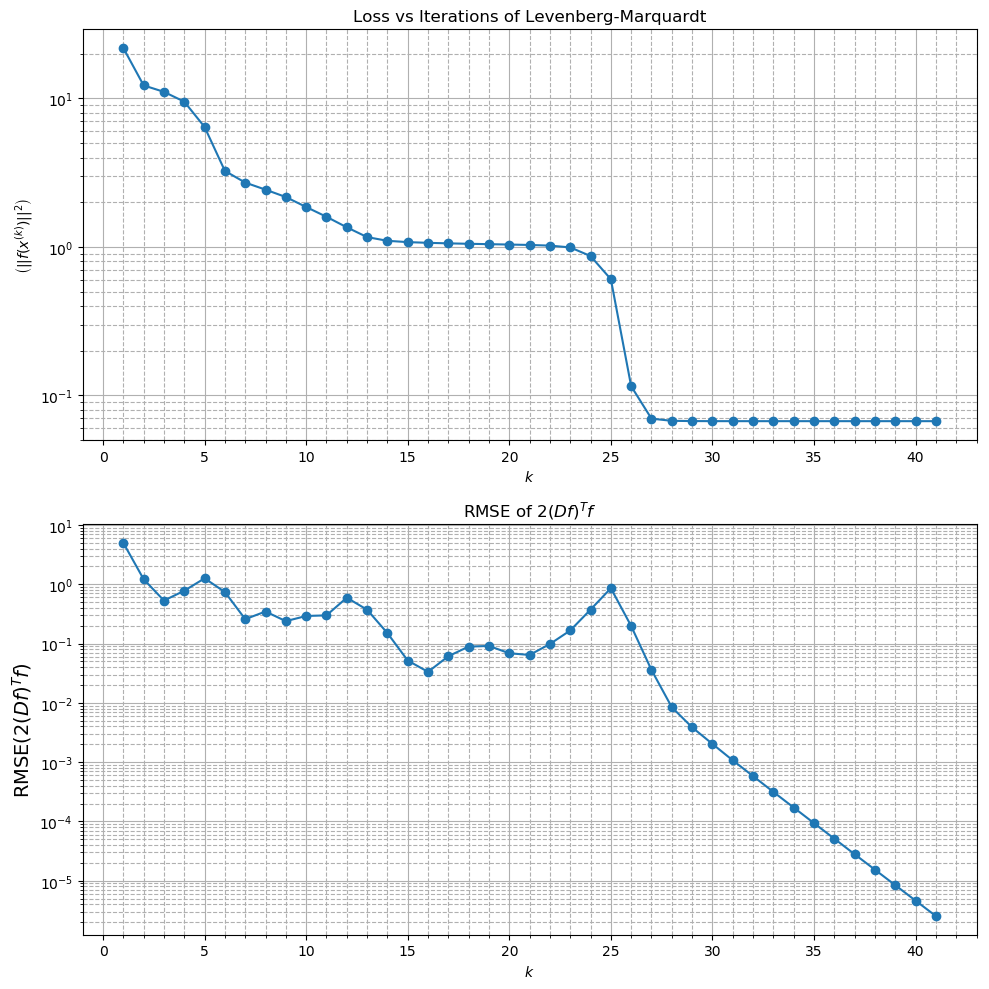

In [43]:
figure(figsize=(10,10));

subplot(211);
x = vec(1:size(fvals, 2));
y = vec(sum(fvals.^2, 1));
semilogy(x, y, marker="o");
title("Loss vs Iterations of Levenberg-Marquardt");
xlabel(L"$k$");
ylabel(L"$\left(||f(x^{(k)})||^2\right)$");

PyPlot.minorticks_on();
grid(true, which="major");
grid(true, which="minor", linestyle="--");

subplot(212);
semilogy(vec(1:size(thetavals, 2)), vec(gradnorm), marker="o");
grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

title(L"RMSE of $2(Df)^Tf$");
xlabel(L"$k$");
ylabel(L"RMSE($2(Df)^Tf$)", fontsize=14);

PyPlot.tight_layout();

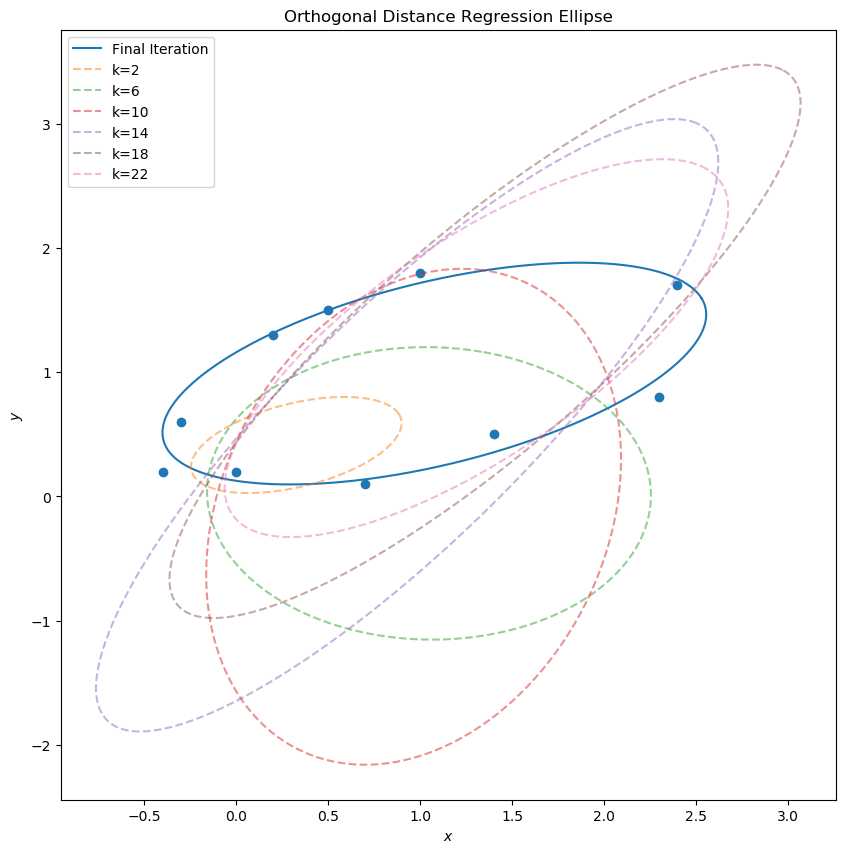

In [41]:
figure(figsize=(10,10))
scatter(X[:,1], X[:,2]);

centerFinal = vec(thetavals[1:2,end]);
semiaxis_lengthsFinal = vec(thetavals[3:4,end]);
ccw_angleFinal = thetavals[5, end];
YFinal = parametric2ellipse_coords(semiaxis_lengthsFinal; center=centerFinal, ccw_angle=ccw_angleFinal, numpoints=1000);

plot(YFinal[1,:], YFinal[2,:], label="Final Iteration");

for k = 2:4:24
    center = vec(thetavals[1:2, k]);
    semiaxis_lengths = vec(thetavals[3:4,k]);
    ccw_angle = thetavals[5, k];
    
    Y = parametric2ellipse_coords(semiaxis_lengths; center=center, ccw_angle=ccw_angle, numpoints=1000);
    plot(Y[1,:], Y[2,:], linestyle="--",alpha=0.5, label="k=$k");
end

title("Orthogonal Distance Regression Ellipse")
xlabel(L"$x$");
ylabel(L"$y$");
legend();